##### Scope

To create a linear regression model that predicts the "price" column in the dataset on San Francisco Apartment rentals. 

A reasonable goal is to get a validation MAE of <= 500 dollars.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

rentals_df = pd.read_csv("../Data/sf_clean.csv") 
rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


In [2]:
rentals = rentals_df

### Data Description

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [3]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


## 1. EDA


In [4]:
rentals.describe()

,price,sqft,beds,bath,hood_district
count,989.000000,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293,7.052578
std,1546.222670,474.629798,1.076710,0.562714,2.404716
min,750.000000,150.000000,0.000000,1.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000,6.000000
50%,3300.000000,900.000000,2.000000,1.000000,8.000000
75%,4242.000000,1200.000000,2.000000,2.000000,9.000000
max,19000.000000,3500.000000,6.000000,4.000000,10.000000


#### 1.1. Correlation matrix and pairplot

In [5]:
rentals_corr = rentals.corr(numeric_only=True)

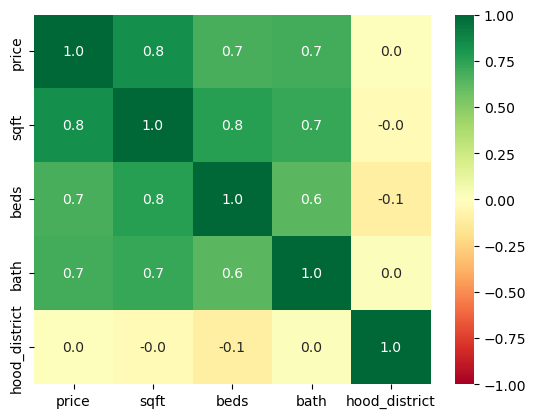

In [6]:
rentals_corr
sns.heatmap(rentals_corr, vmin=-1, vmax=1, cmap='RdYlGn', annot=True, fmt=".1f");

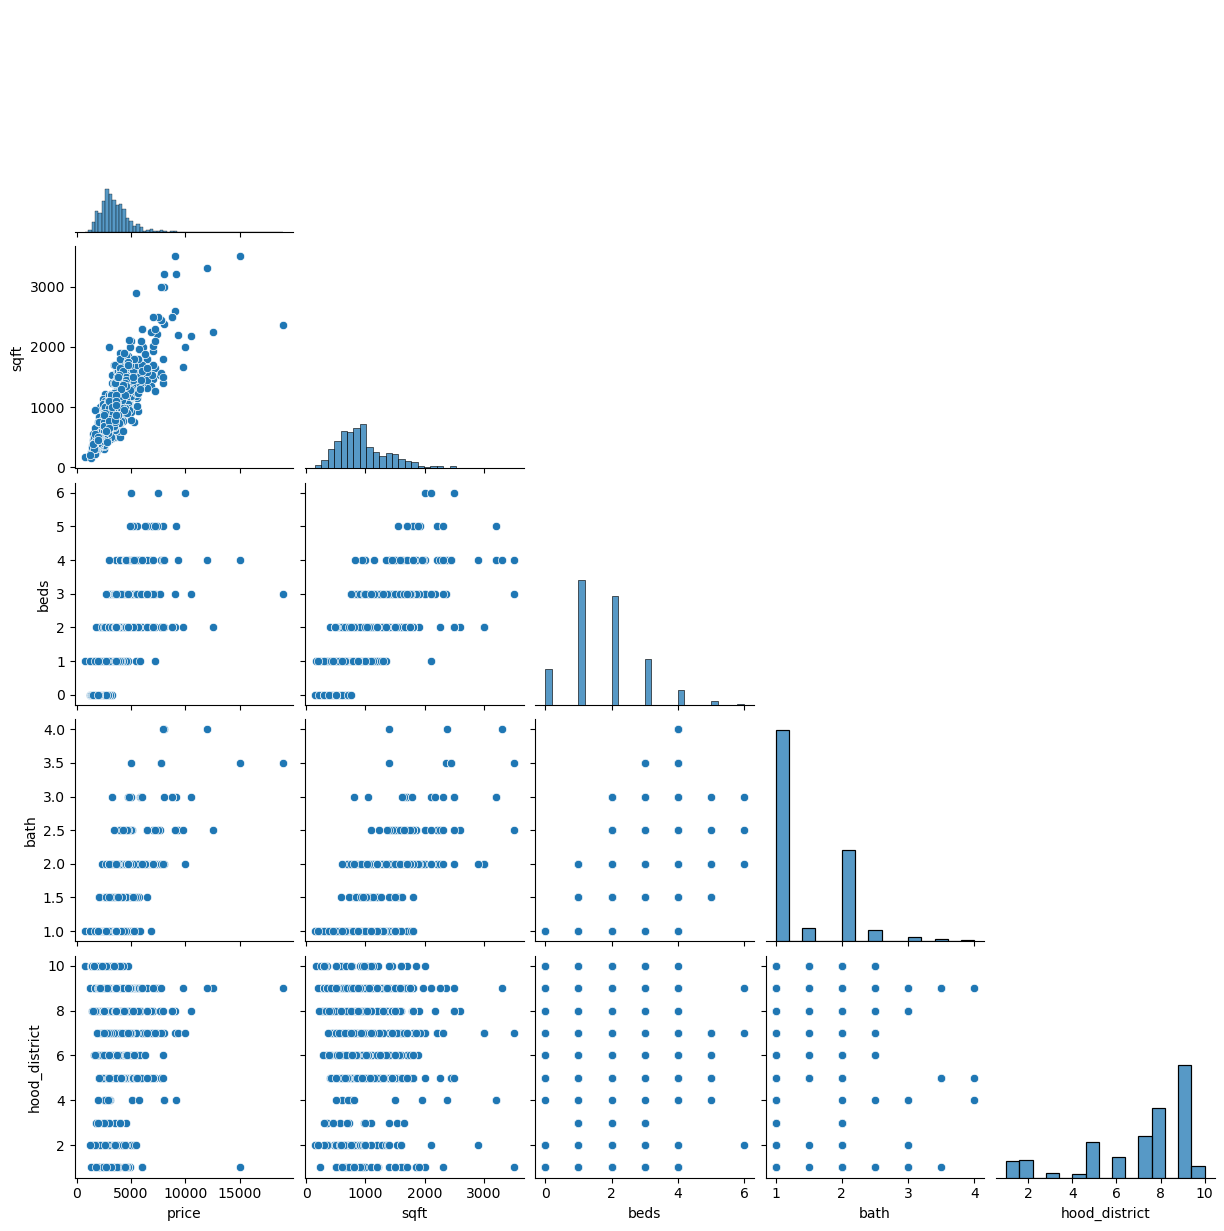

In [7]:
sns.pairplot(rentals.select_dtypes("number"), corner=True);

##### Comments:

Bath, beds, and sqft seems to be correlated with target variables price.

Considering the slopes and spreads of values. There might be a variable that may interact with those variables on their influence on price.

Bath, beds, and sqft are also correlated with themselves.



Hood_district has no correlation with price and other numeric variables.

### 1.2. Detailed insights

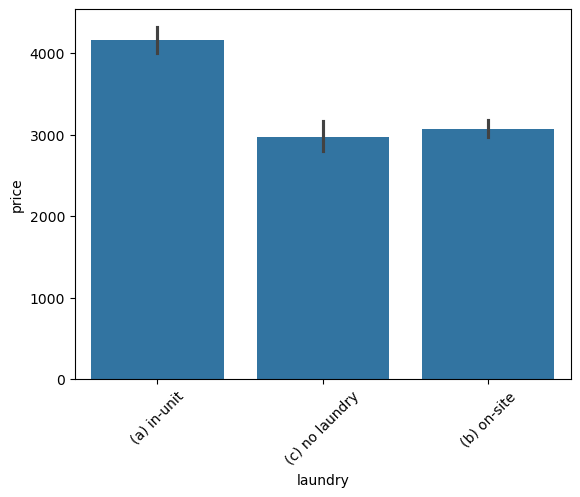

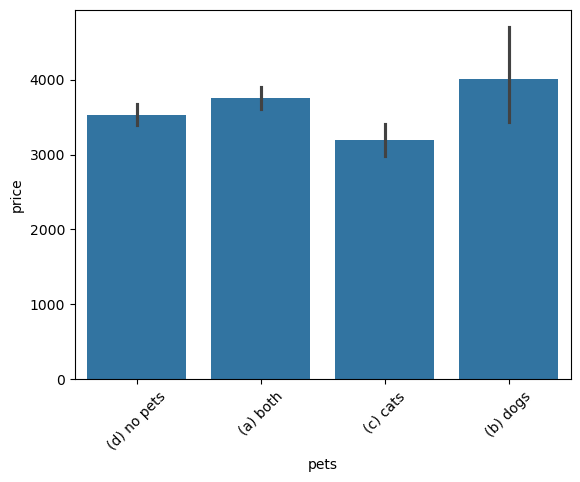

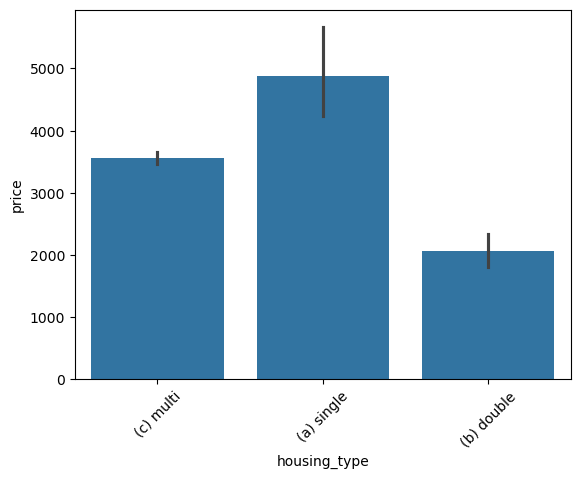

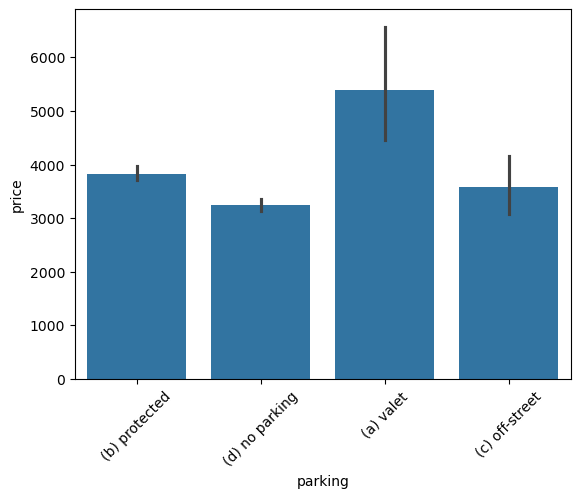

In [8]:
def cat_plotter(data, target):
    for col in data.select_dtypes(["object"]).columns:
        sns.barplot(data=data, x=col, y=target)
        plt.xticks(rotation=45)
        plt.show()
        
cat_plotter(rentals, "price")

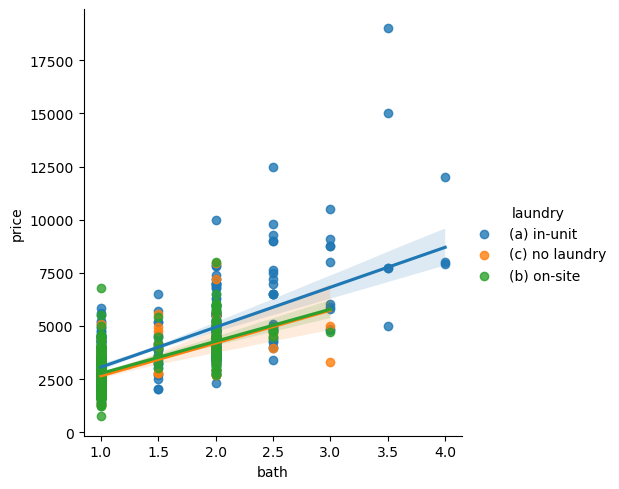

In [9]:
# Does laundry solution impacts the bath relationship on price?

sns.lmplot(rentals, x='bath', y='price', hue='laundry');

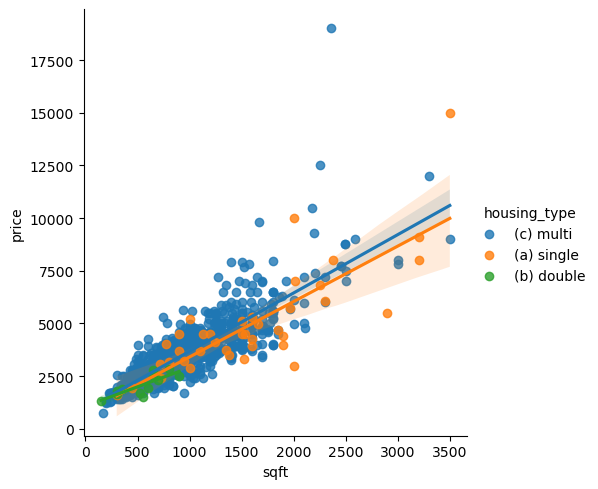

In [10]:
# Does housing_type solution impacts the bath relationship on price?

sns.lmplot(rentals, x='sqft', y='price', hue='housing_type');

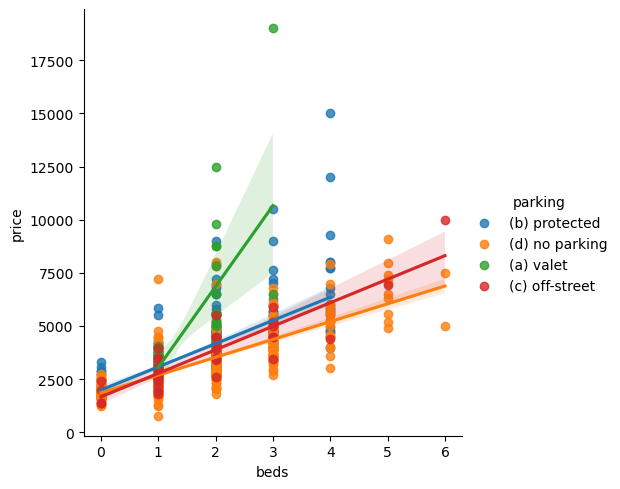

In [11]:
sns.lmplot(rentals, x='beds', y='price', hue='parking');

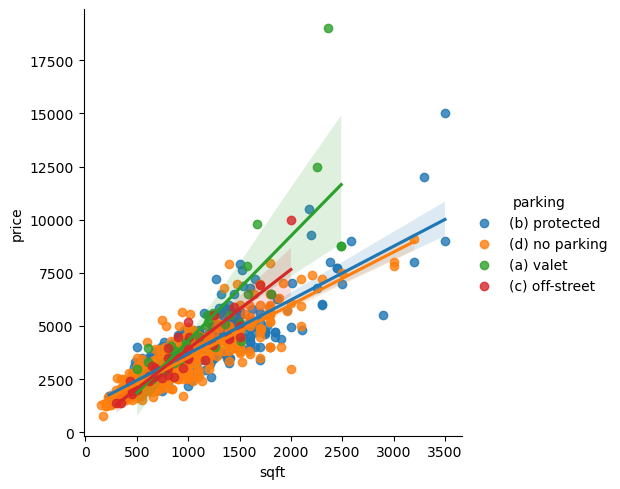

In [12]:
sns.lmplot(rentals, x='sqft', y='price', hue='parking');

##### Comment:

It seems that valet service has a visible inflence (parking) on other variables. 

### 1.3. Exploration of sqft

In [13]:
rentals['sqft'].describe()

count     989.000000
mean      976.765420
std       474.629798
min       150.000000
25%       650.000000
50%       900.000000
75%      1200.000000
max      3500.000000
Name: sqft, dtype: float64

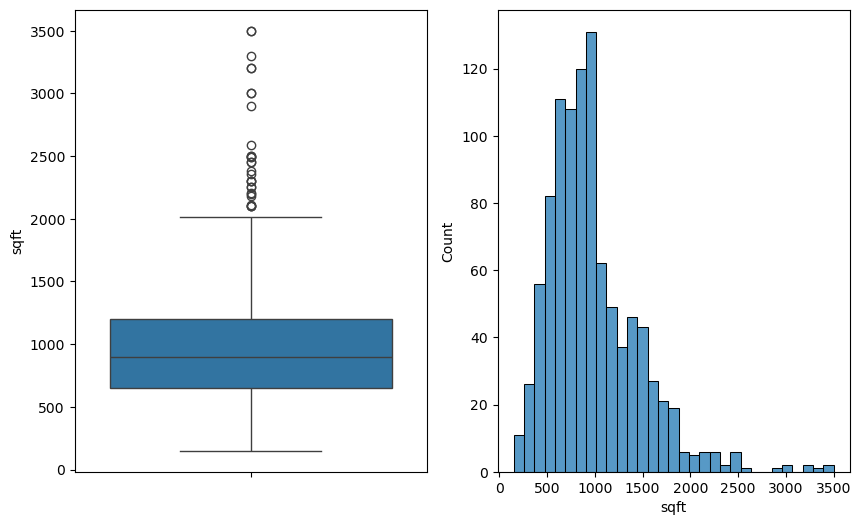

In [14]:
# sqft_boxplot = sns.boxplot(rentals['sqft']);


fig, ax = plt.subplots(1, 2, figsize=(10, 6))

sqft_boxplot = sns.boxplot(rentals['sqft'], ax=ax[0]);

sqft_hist = sns.histplot(rentals['sqft'], ax=ax[1]);


In [15]:
rentals['house_size'] = pd.cut(rentals['sqft'],
                              bins=[0,1000,2000,3500],
                              labels=['below_median', 'above_median', 'outlier'])

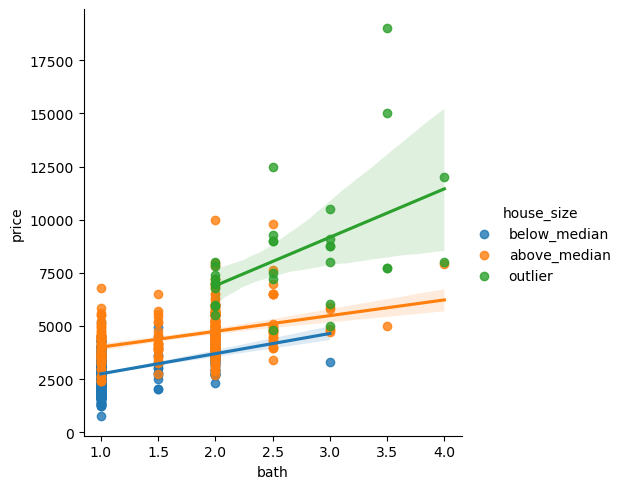

In [16]:
sns.lmplot(rentals, x='bath', y='price', hue='house_size');

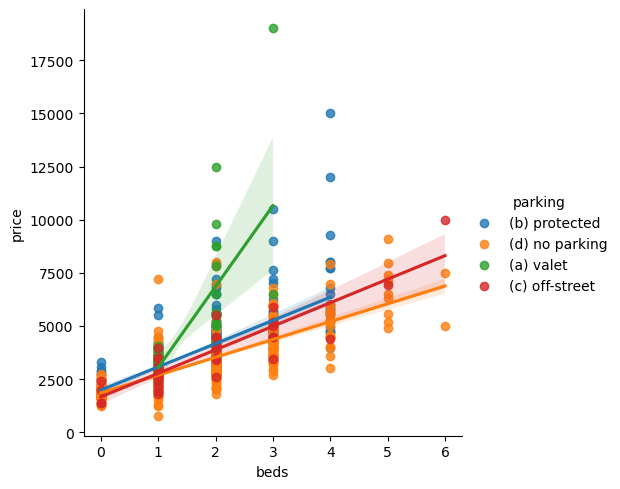

In [17]:
sns.lmplot(rentals, x='beds', y='price', hue='parking');

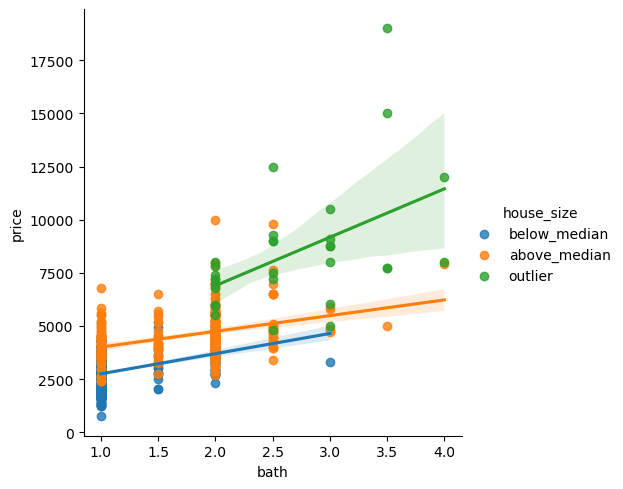

In [18]:
sns.lmplot(rentals, x='bath', y='price', hue='house_size');

### 1.4. Geographic exploration

In [19]:
district_dict = {1: "outskirts_west",
                 2: "outskirts_west",
                 3: "outskirts_west",
                 4: "outskirts_west",
                 5: "central",
                 6: "central",
                 7: "central",
                 8: "central",
                 9: "central",
                 10: "outskirts_south",
                 11: "outskirts_south"}
                  
rentals['districts_agg'] = rentals['hood_district'].map(district_dict)
rentals['districts_agg']

0             central
1             central
2             central
3             central
4             central
            ...      
984           central
985           central
986    outskirts_west
987           central
988           central
Name: districts_agg, Length: 989, dtype: object

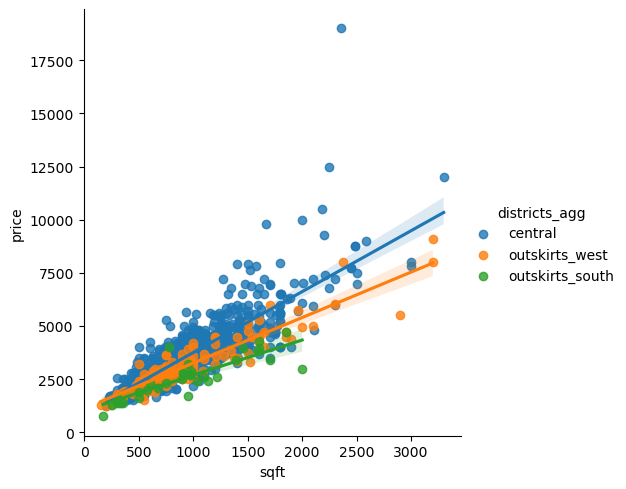

In [20]:
sns.lmplot(rentals.query('sqft < 3500'), x='sqft', y='price', hue='districts_agg');


### 1.5. Exploration Pets

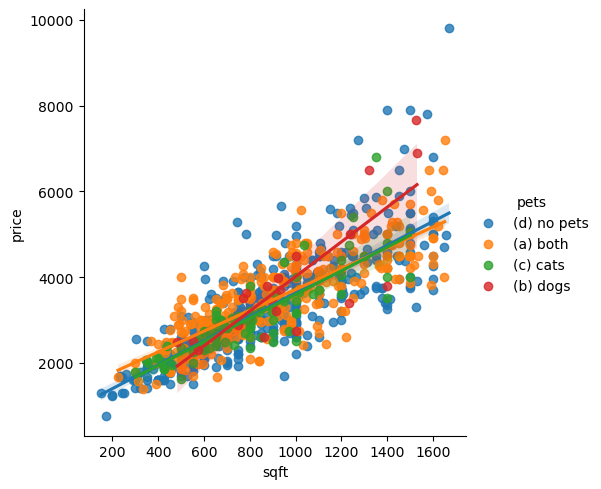

In [21]:
sns.lmplot(rentals.query('sqft < 1700'), x='sqft', y='price', hue='pets');

In [22]:
dogs_dict = {'(b) dogs': 1,
             '(d) no pets': 0,
             '(c) cats': 0,
             '(a) both': 1,             
            }
                  
rentals['dogs'] = rentals['pets'].map(dogs_dict)

In [23]:
rentals['dogs']

0      0
1      0
2      0
3      0
4      0
      ..
984    0
985    0
986    0
987    0
988    0
Name: dogs, Length: 989, dtype: int64

### 1.6. Explorations of beds

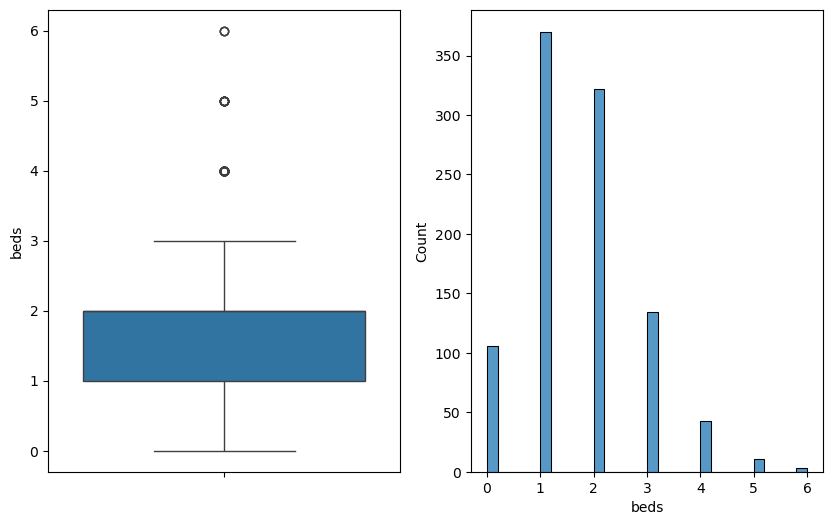

In [24]:
# sqft_boxplot = sns.boxplot(rentals['sqft']);


fig, ax = plt.subplots(1, 2, figsize=(10, 6))

sqft_boxplot = sns.boxplot(rentals['beds'], ax=ax[0]);

sqft_hist = sns.histplot(rentals['beds'], ax=ax[1]);


## 2. Feature Engineering


#### 2.1. Transforming "laundry" into dummies

In [25]:
rentals['laundry'].unique()

array(['(a) in-unit', '(c) no laundry', '(b) on-site'], dtype=object)

In [26]:
dummy_laundry = pd.get_dummies(rentals['laundry'], dtype=int).rename(columns={'(a) in-unit': 'laundry_inunit', 
                                                                              '(b) on-site': 'laundry_onsite', 
                                                                              '(c) no laundry': 'laundry_no'})

rentals = rentals.merge(dummy_laundry, how='left', left_index=True, right_index=True)

Using the sieved districts for modeling. Assumption the prices in downtown will be higher.

In [27]:
rentals['districts_agg']

0             central
1             central
2             central
3             central
4             central
            ...      
984           central
985           central
986    outskirts_west
987           central
988           central
Name: districts_agg, Length: 989, dtype: object

In [28]:
dummy_geography = pd.get_dummies(rentals['districts_agg'], dtype=int).rename(columns={'central': 'dist_central', 
                                                                                      'outskirts_south': 'dist_outskirts_south',
                                                                                      'outskirts_west': 'dist_outskirts_west'})

rentals = rentals.merge(dummy_geography, how='left', left_index=True, right_index=True)

#### 2.2. Turning "housing_type" into dummies

In [29]:
rentals['housing_type'].unique()

array(['(c) multi', '(a) single', '(b) double'], dtype=object)

In [30]:
dummy_type = pd.get_dummies(rentals['housing_type'], dtype=int).rename(columns={'(c) multi': 'type_multi', 
                                                                                '(a) single': 'type_single',
                                                                                '(b) double': 'type_double'})


rentals = rentals.merge(dummy_type, how='left', left_index=True, right_index=True)

##### Comment:

Separate treatment of single, double, and multi doesn't seem to have an effect. Below a different approach is prepared where division onto multi and non_multi units was conducted.

In [31]:
housing_type_dict = {'(c) multi': 0, 
                 '(a) single': 1,
                 '(b) double': 1}
                  
rentals['non_multi'] = rentals['housing_type'].map(housing_type_dict)

#### 2.3. Aggregating beds

##### Comment:

Aggregating beds to make a bigger bins for that data. More than normal seems to be at two or three bedrooms.

In [32]:
two_beds_dict = {0: 0, 
                 1: 0,
                 2: 0,
                 3: 1,
                 4: 1,
                 5: 1,
                 6: 1}
                  
rentals['more_than_two_beds'] = rentals['beds'].map(two_beds_dict)

In [33]:
three_beds_dict = {0: 0, 
                 1: 0,
                 2: 0,
                 3: 0,
                 4: 1,
                 5: 1,
                 6: 1}
                  
rentals['more_than_three_beds'] = rentals['beds'].map(three_beds_dict)

In [34]:
four_beds_dict = {0: 0, 
                 1: 0,
                 2: 0,
                 3: 0,
                 4: 0,
                 5: 1,
                 6: 1}
                  
rentals['more_than_four_beds'] = rentals['beds'].map(four_beds_dict)

In [35]:
rentals['beds_sq'] = rentals['beds'] ** 2

In [36]:
rentals['beds_cb'] = rentals['beds'] ** 3

Checking if beds per sqft will better describe the target variable.

In [37]:
rentals['beds_per_sqft'] = rentals['beds'] / rentals['sqft']

Checking if baths per sqft will have a similar impact.

In [38]:
rentals['baths_per_sqft'] = rentals['bath'] / rentals['sqft']

#### 2.4. Extracting valet service

In [39]:
valet_service_type_dict = {'(a) valet': 1, 
                           '(b) protected': 0,
                           '(c) off-street': 0,                     
                           '(d) no parking': 0}
                  
rentals['valet'] = rentals['parking'].map(valet_service_type_dict)

In [40]:
other_parking_type_dict = {'(a) valet': 0, 
                     '(b) protected': 1,
                     '(c) off-street': 1,                     
                     '(d) no parking': 0}
                  
rentals['other_parking'] = rentals['parking'].map(other_parking_type_dict)

In [41]:
rentals['other_parking'].isna().sum()

0

#### 2.5. Checking if huge floor space had a value making impact

Refining sqft variable by aggregating it to more than 2000 sqft and others.

In [42]:
parking_type_dict = {'below_median': 0, 
                     'above_median': 0,
                     'outlier': 1}
                  
rentals['above_2000sqft'] = rentals['house_size'].map(parking_type_dict)

In [43]:
rentals['above_2000sqft_non_multi'] = np.where((rentals['above_2000sqft'] == 1) & (rentals['non_multi'] == 1), 1, 0)

In [44]:
rentals['above_2000sqft_single'] = np.where((rentals['above_2000sqft'] == 1) & (rentals['type_single'] == 1), 1, 0)

In [45]:
rentals['above_2000sqft_multi'] = np.where((rentals['above_2000sqft'] == 1) & (rentals['type_multi'] == 1), 1, 0)

In [46]:
rentals['above_2000sqft_multi_central'] = np.where((rentals['above_2000sqft'] == 1) & (rentals['type_multi'] == 1) & (rentals['dist_central'] == 1), 1, 0)

## 3. Data Splitting

In [47]:
from sklearn.model_selection import train_test_split

#features = ['sqft','beds','bath','hood_district']
features = ['sqft',
            'above_2000sqft',
            # 'above_2000sqft_non_multi',
            # 'above_2000sqft_single',
            # 'above_2000sqft_multi',
            # 'above_2000sqft_multi_central',
            # 'beds',
            # 'beds_sq',
            'beds_per_sqft',
            # 'beds_cb',
            # 'more_than_two_beds',           
            # 'more_than_three_beds',
            # 'more_than_four_beds',
            'bath',
            # 'baths_per_sqft',
            # 'laundry',
            'laundry_inunit',
            # 'laundry_onsite',
            # 'pets',
            # 'dogs',
            # 'housing_type',
            # 'type_single',
            # 'type_double',
            # 'non_multi',
            # 'parking',
            'valet',
            'other_parking',
            # 'districts_agg',
            'dist_central',
            'dist_outskirts_west'
            # 'hood_district'
           ]

X = sm.add_constant(rentals[features])
#y = rentals['price']
y = np.log(rentals['price'])

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

In [48]:
model = sm.OLS(y, X).fit()

## 4. Model Fitting & Validation Scoring

In [49]:
def cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)
    # Create a list to store validation scores for each fold

    cv_lm_tr_r2s = []
    cv_lm_tr_mae = []
    cv_lm_val_r2s = []
    cv_lm_val_mae = []
    
    for train_ind, val_ind in kf.split(X, y):
        # Subset data based on CV folds
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        # Fit the Model on fold's training data
        model = sm.OLS(y_train, X_train).fit()
        # Append Validation score to list 
        cv_lm_tr_r2s.append(r2(y_train, model.predict(X_train)))
#        cv_lm_tr_mae.append(mae(y_train, model.predict(X_train)))
        cv_lm_tr_mae.append(mae(np.exp(y_train), np.exp(model.predict(X_train))))
        cv_lm_val_r2s.append(r2(y_val, model.predict(X_val),))
#        cv_lm_val_mae.append(mae(y_val, model.predict(X_val),))
        cv_lm_val_mae.append(mae(np.exp(y_val), np.exp(model.predict(X_val)),))        
        
    print(f"All Training R2s: {[round(x, 3) for x in cv_lm_tr_r2s]}")
    print(f"Training R2s: {round(np.mean(cv_lm_tr_r2s), 3)} +- {round(np.std(cv_lm_tr_r2s), 3)}")
    
    print(f"Training MAEs: {[round(x, 3) for x in cv_lm_tr_mae]}")
    print(f"Training MAEs: {round(np.mean(cv_lm_tr_mae), 3)} +- {round(np.std(cv_lm_tr_mae), 3)}")    
  
    print(f"All Validation R2s: {[round(x, 3) for x in cv_lm_val_r2s]}")
    print(f"Cross Val R2s: {round(np.mean(cv_lm_val_r2s), 3)} +- {round(np.std(cv_lm_val_r2s), 3)}")

    print(f"All Validation MAEs: {[round(x, 3) for x in cv_lm_val_mae]}")
    print(f"Cross Val MAEs: {round(np.mean(cv_lm_val_mae), 3)} +- {round(np.std(cv_lm_val_mae), 3)}")
    
    return model

In [50]:
cross_validation(X, y, 5);

All Training R2s: [0.812, 0.811, 0.807, 0.804, 0.818]
Training R2s: 0.811 +- 0.005
Training MAEs: [508.1, 468.784, 480.786, 500.482, 478.551]
Training MAEs: 487.34 +- 14.617
All Validation R2s: [0.796, 0.805, 0.819, 0.832, 0.774]
Cross Val R2s: 0.805 +- 0.02
All Validation MAEs: [422.759, 563.153, 511.674, 446.873, 518.414]
Cross Val MAEs: 492.575 +- 50.944


## 5. Assumptions Checking

In [51]:
def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0], alpha=.3)
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")
    #ax[1].set_xlim(-3,3)
    ax[1].set_xlim(-2,2)

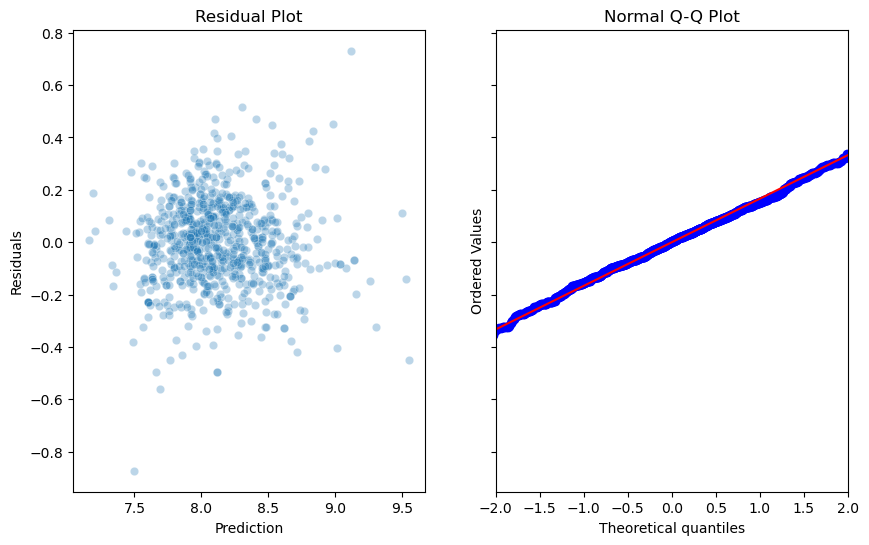

In [52]:
residual_analysis_plots(model)

##### Comment:

Residual plot shows an even destribution of residuals and Q-Q proves normality in -2 +2 range.

In [53]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     370.0
Date:                Tue, 16 Apr 2024   Prob (F-statistic):          1.03e-274
Time:                        23:48:14   Log-Likelihood:                 293.65
No. Observations:                 791   AIC:                            -567.3
Df Residuals:                     781   BIC:                            -520.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.9643      0.040    175.959      0.000       6.887       7.042
sqft                    0.0006   2.06e-05     28.634      0.000       0.001       0.001
above_2000sqft         -0.1429      0.042     -3.414      0.001      -0.225      -0.061
beds_per_sqft          64.5692      7.614      8.480      0.000      49.623      79.516
bath                    0.0486      0.016      3.039      0.002       0.017       0.080
laundry_inunit          0.0741      0.013      5.504      0.000       0.048       0.101
valet                   0.2274      0.033      6.870      0.000       0.162       0.292
other_parking           0.0656      0.013      5.136      0.000       0.041       0.091
dist_central            0.3560      0.036      9.967      0.000       0.286       0.426
dist_outskirts_west     0.2361      0.039      6.029      0.000       0.159       0.313
==============================================================================
Omnibus:                       28.814   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.919
Skew:                          -0.128   Prob(JB):                     1.78e-15
Kurtosis:                       4.412   Cond. No.                     1.41e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Comment:

P-values show significance for the selected variables. The small difference between R-sq and adj. R-sq proves lack of overfitting. With D-W around 1.9 there's no reason to assume autocorrelation.

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

variables = sm.OLS(y, X).exog

pd.Series([vif(variables, i) for i in range(variables.shape[1])], index=X.columns)

const                  43.905186
sqft                    2.871276
above_2000sqft          1.734108
beds_per_sqft           1.131309
bath                    2.332037
laundry_inunit          1.271348
valet                   1.120803
other_parking           1.141025
dist_central            4.726417
dist_outskirts_west     4.786931
dtype: float64

##### Comment:

VIF values for variables are no greater than 5.0 - there's reason to address colinearality.

In [55]:
influence = model.get_influence()
inf_summary = influence.summary_frame()
inf_summary['cooks_d'].sort_values(ascending=False).head()

56     0.307753
253    0.146780
602    0.050612
954    0.047211
3      0.043152
Name: cooks_d, dtype: float64

##### Comment:

No highly influential (> 1.0) data points were detected with Cook's Distances.

## 6. Final Model Fit & Test Scoring

In [56]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae

### 6.1. Train Performance

In [57]:
print(f"Train R2: {r2(y, model.predict(X))}")
# print(f"Train MAE: {mae(y, model.predict(X))}")
print(f"Train MAE: {mae(np.exp(y), np.exp(model.predict(X)))}")


Train R2: 0.8100397550497377
Train MAE: 487.84991893643075


### 6.2. Test Performance

In [61]:
print(f"Test R2: {r2(y_test, model.predict(X_test))}")
# print(f"Test MAE: {mae(y_test, model.predict(X_test))}")
print(f"Test MAE: {mae(np.exp(y_test), np.exp(model.predict(X_test)))}")

Test R2: 0.7739771758953544
Test MAE: 453.0495554165729
